# Randomizing the System

## Overview

### Questions

* How can I generate a random initial condition?

### Objectives

* Show how to use HPMC to **randomize** the **initial condition**.
* Demonstrate how to **run** a simulation.
* Show how to use HPMC integrator properties to examine the **acceptance ratio**.
* Explain that short simulations at low density effectively randomize the system.

## Boilerplate code

In [1]:
import hoomd
import math

The `render` function in the next cell will render a snapshot using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel

device = fresnel.Device()

def render(snapshot):
    vertices=[(-0.5, 0, 0),
               (0.5, 0, 0),
               (0, -0.5, 0),
               (0, 0.5, 0),
               (0, 0, -0.5),
               (0, 0, 0.5)]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene,
                                                 poly_info,
                                                 N=snapshot.particles.N)
    geometry.material = fresnel.material.Material(color=(0.1, 0.7, 0.25),
                                                  roughness=0.8)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=.02)
    

    scene.lights = fresnel.light.lightbox()
    scene.camera = fresnel.camera.fit(scene, view='front', margin=0)
    return fresnel.pathtrace(scene, samples=500)

## Method

The previous section of this tutorial placed all the particles on a simple cubic lattice.
This is a convenient way to place non-overlapping particles, but it starts the simulation in a highly ordered state.
We should **randomize** the the system enough so that it forgets this initial state and self-assembly to the final ordered state can proceed without influence by the initial condition.

We cannot simply draw random numbers for the particle positions, as that will result in overlaps between particles.
Instead, we will start from the lattice and use HPMC to move particles randomly while ensuring that they do not overlap.
In low density configurations, like the lattice generated in the previous section, a short simulation will quickly **randomize** the system.

## Set up the simulation

The following code block creates the **Simulation**, configures the HPMC **integrator**, and initializes the system **state** from `lattice.gsd` as has been discussed in previous sections in this tutorial:

In [3]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu)

mc = hoomd.hpmc.integrate.ConvexPolyhedron(seed=42)
mc.shape['octahedron'] = dict(vertices=[(-0.5, 0, 0),
                                         (0.5, 0, 0),
                                         (0, -0.5, 0),
                                         (0, 0.5, 0),
                                         (0, 0, -0.5),
                                         (0, 0, 0.5)])

sim.operations.integrator = mc
sim.create_state_from_gsd(filename='lattice.gsd')

HOOMD-blue v2.9.0-1828-gd903f0dc6 GPU [CUDA] (10.2) DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 06/22/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
HOOMD-blue is running on the CPU


## Run the simulation

Before we **run** the simulation, let's save a snapshot of the current state of the system.
We will use this later to see how far particles have moved.

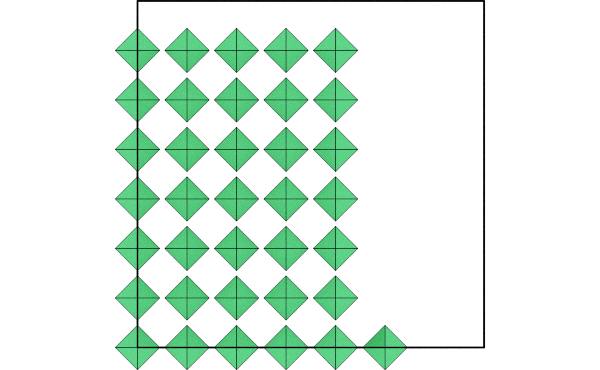

In [4]:
initial_snapshot = sim.state.snapshot
render(initial_snapshot)

**Run** the simulation to **randomize** the particle positions and orientations.
The `run` method takes the number of steps to run as an argument.
10,000 steps should be enough to **randomize** a low density system:

In [5]:
sim.run(10e3)

We can query properties of the HPMC **integrator** to see what it did.
`translate_moves` is a tuple with the number of accepted and rejected translation moves.
The **acceptance ratio**, the fraction of attempted moves which is accepted, is very high at this low density.

In [6]:
mc.translate_moves

(4487137, 511940)

In [7]:
mc.translate_moves[0] / sum(mc.translate_moves)

0.8975930956854635

`rotate_moves` similarly provides the number of accepted and rejected rotation moves.

In [8]:
mc.rotate_moves

(4751958, 248965)

In [9]:
mc.rotate_moves[0] / sum(mc.rotate_moves)

0.9502161900913092

`overlaps` reports the number of overlapping particle pairs in the **state**.
There are no overlaps in the final configuration:

In [10]:
mc.overlaps

0

## The final configuration

Let's look at the final particle positions and orientations and see how they have changed.

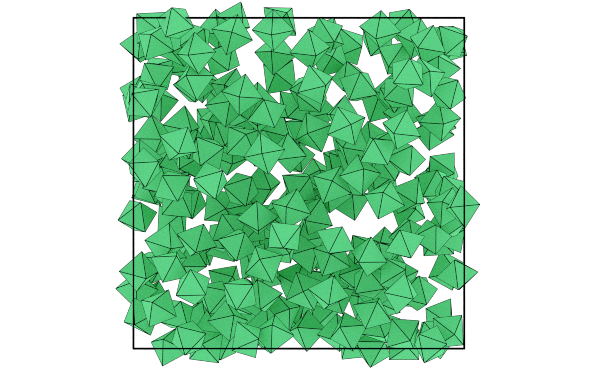

In [11]:
final_snapshot = sim.state.snapshot
render(final_snapshot)

In [12]:
initial_snapshot.particles.position[0:4]

array([[-3.8499999 , -3.8499999 , -3.8499999 ],
       [-3.8499999 , -3.8499999 , -2.75      ],
       [-3.8499999 , -3.8499999 , -1.64999998],
       [-3.8499999 , -3.8499999 , -0.55000001]])

In [13]:
final_snapshot.particles.position[0:4]

array([[ 1.54900315, -2.76740295, -2.42178701],
       [ 2.41612748, -3.50971833,  1.29888455],
       [ 0.69325227, -2.54684849,  3.0261388 ],
       [-3.25838997, -2.91447959,  2.20726177]])

In [14]:
initial_snapshot.particles.orientation[0:4]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [15]:
final_snapshot.particles.orientation[0:4]

array([[-0.09892163, -0.95662332,  0.19316517, -0.19435419],
       [-0.46794988,  0.13993626,  0.65949795, -0.5714046 ],
       [-0.24322189,  0.74507114,  0.59229941,  0.18679807],
       [-0.50958868, -0.62684335, -0.21881789,  0.54727099]])

The particle positions and orientations have indeed changed significantly, telling us that the system is well **randomized**.
Let's save the final configuration to a GSD file for use in the next stage of the simulation.

In [16]:
hoomd.dump.GSD.write_state(state=sim.state, filename='random.gsd')

We will take `random.gsd` and compress it down to a higher density in the next section of this tutorial.

[Previous section](03-Initializing-the-System-State.ipynb). [Next section](05-Compressing-the-System.ipynb).